<a href="https://colab.research.google.com/github/KaroAntonio/dsc/blob/master/Unit%2014%20-%20Supervised%20Learning/14.5%20Ensemble%20Methods%20Gradient%20Boosting%20and%20AdaBoost/Gradient%20Boosting%20Case%20Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [15]:
# Clone my fork of the case study into Colab
!git clone https://github.com/karoantonio/dsc.git

Cloning into 'dsc'...
remote: Enumerating objects: 684, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 684 (delta 155), reused 164 (delta 128), pack-reused 446
Receiving objects: 100% (684/684), 60.57 MiB | 20.83 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [16]:
%ls dsc/'Unit 14 - Supervised Learning'/'14.5 Ensemble Methods Gradient Boosting and AdaBoost'/

'Gradient Boosting Case Study.ipynb'  'Gradient Boosting Case Study.zip'   titanic.csv


In [17]:
%cd dsc/'Unit 14 - Supervised Learning'/'14.5 Ensemble Methods Gradient Boosting and AdaBoost'/

/content/dsc/Unit 14 - Supervised Learning/14.5 Ensemble Methods Gradient Boosting and AdaBoost/dsc/Unit 14 - Supervised Learning/14.5 Ensemble Methods Gradient Boosting and AdaBoost


### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [18]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [20]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [21]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [22]:
X_new = np.array([[0.8]])

In [23]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [24]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

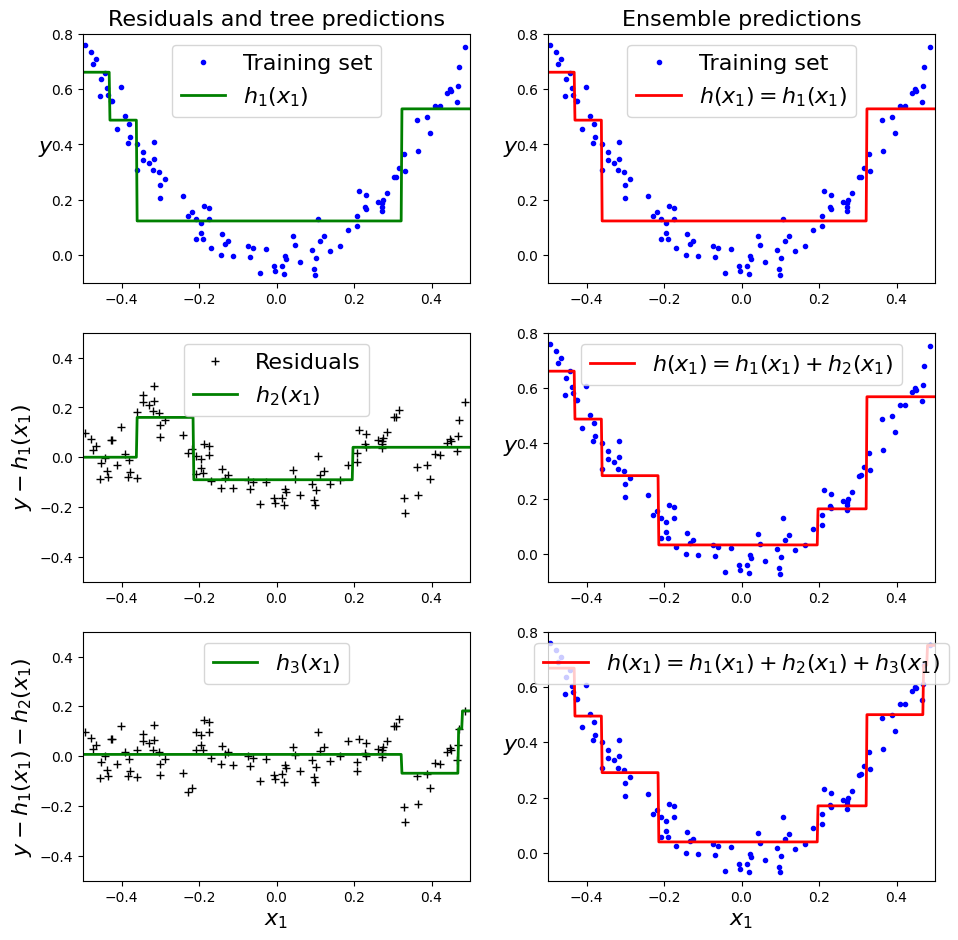

In [25]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations.

In [29]:
df = pd.read_csv('titanic.csv', index_col = 'PassengerId')
df.dropna(inplace = True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 2 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  183 non-null    int64  
 1   Pclass    183 non-null    int64  
 2   Name      183 non-null    object 
 3   Sex       183 non-null    object 
 4   Age       183 non-null    float64
 5   SibSp     183 non-null    int64  
 6   Parch     183 non-null    int64  
 7   Ticket    183 non-null    object 
 8   Fare      183 non-null    float64
 9   Cabin     183 non-null    object 
 10  Embarked  183 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 17.2+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [30]:
df.select_dtypes(include = 'object')

,Name,Sex,Ticket,Cabin,Embarked
PassengerId,,,,,
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
7,"McCarthy, Mr. Timothy J",male,17463,E46,S
11,"Sandstrom, Miss. Marguerite Rut",female,PP 9549,G6,S
12,"Bonnell, Miss. Elizabeth",female,113783,C103,S
...,...,...,...,...,...
872,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,11751,D35,S
873,"Carlsson, Mr. Frans Olof",male,695,B51 B53 B55,S
880,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,11767,C50,C


**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [31]:
LOW_INFO_COLS = ['Name','Cabin','Ticket']
dfo = df.select_dtypes(include = 'object')
# Only get dummy features for categorical cols with useful seeming info
dummy_feats = pd.get_dummies(dfo.drop(LOW_INFO_COLS,axis =1))
df = pd.DataFrame(df.drop(dfo.columns,axis =1)).merge(dummy_feats, left_index=True,right_index=True)
print(df.shape)
df.head()

(183, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
2,1,1,38.0,1,0,71.2833,1,0,1,0,0
4,1,1,35.0,1,0,53.1000,1,0,0,0,1
7,0,1,54.0,0,0,51.8625,0,1,0,0,1
11,1,3,4.0,1,1,16.7000,1,0,0,0,1
12,1,1,58.0,0,0,26.5500,1,0,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [32]:
df.isnull().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [33]:
X = df.drop('Survived',axis =1)
y = df.Survived

**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [34]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [50]:
from os import access
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.15, 1.25, 1.5]

for learning_rate in learning_rates:
    # Run the GBC 10 times with different seeds to get a better idea of the acc
    acc_trains = []
    acc_tests = []
    n_runs = 20
    for rand_seed in range(n_runs):
      gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = rand_seed*15)
      gb.fit(X_train, y_train)
      acc_train = gb.score(X_train, y_train)
      acc_trains.append(acc_train)
      acc_test = gb.score(X_test, y_test)
      acc_tests.append(acc_test)
    avg_acc_train = np.mean(acc_trains)
    avg_acc_test = np.mean(acc_tests)
    print("N Runs: ", n_runs)
    print("Learning rate: ", learning_rate)
    print("Avg Accuracy score (training): {0:.3f}".format(avg_acc_train))
    print("Avg Accuracy score (validation): {0:.3f}".format(avg_acc_test))

N Runs:  20
Learning rate:  0.05
Avg Accuracy score (training): 0.747
Avg Accuracy score (validation): 0.613
N Runs:  20
Learning rate:  0.1
Avg Accuracy score (training): 0.830
Avg Accuracy score (validation): 0.708
N Runs:  20
Learning rate:  0.25
Avg Accuracy score (training): 0.858
Avg Accuracy score (validation): 0.710
N Runs:  20
Learning rate:  0.5
Avg Accuracy score (training): 0.895
Avg Accuracy score (validation): 0.720
N Runs:  20
Learning rate:  0.75
Avg Accuracy score (training): 0.911
Avg Accuracy score (validation): 0.740
N Runs:  20
Learning rate:  1
Avg Accuracy score (training): 0.926
Avg Accuracy score (validation): 0.738
N Runs:  20
Learning rate:  1.15
Avg Accuracy score (training): 0.933
Avg Accuracy score (validation): 0.728
N Runs:  20
Learning rate:  1.25
Avg Accuracy score (training): 0.931
Avg Accuracy score (validation): 0.741
N Runs:  20
Learning rate:  1.5
Avg Accuracy score (training): 0.905
Avg Accuracy score (validation): 0.727


**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [60]:
# Using the best found learning rate
BEST_LEARNING_RATE = 1.15
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = BEST_LEARNING_RATE, max_features=2, max_depth = 2, random_state = 1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

# Format the Confusion Matrix
conf_matrix = confusion_matrix(y_test, gb.predict(X_test))
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print(f'Confusion Matrix')
print(conf_matrix_df)
print(f'Classification Report')
print(classification_report(y_test, gb.predict(X_test)))

Confusion Matrix
          Predicted 0  Predicted 1
Actual 0           12            6
Actual 1            6           22
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        18
           1       0.79      0.79      0.79        28

    accuracy                           0.74        46
   macro avg       0.73      0.73      0.73        46
weighted avg       0.74      0.74      0.74        46



**<font color='teal'>Calculate the ROC for the model as well.</font>**

ROC AUC Score: 0.7261904761904762


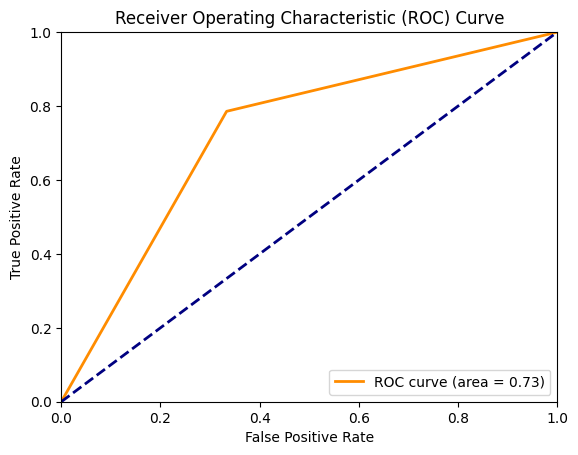

In [67]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC score
roc_auc_score = auc(fpr, tpr)

print(f'ROC AUC Score: {roc_auc_score}')

# Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()